In [1]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from PIL import Image
from mtcnn.mtcnn import MTCNN
import mtcnn
from matplotlib import pyplot as plt
from numpy import expand_dims
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import matplotlib.image as mpimg
import cv2
from scipy.spatial.distance import cosine
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(mtcnn.__version__)
tf.__version__

0.1.0


'2.3.1'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2.5GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2500)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
def extract_face(filename, required_size=(160, 160)):
    
    image = load_img(filename)
    image_arr = img_to_array(image)
    
    detector = MTCNN()
    results = detector.detect_faces(image_arr)
    
    # extract the bounding box from the first face
    #print(results)
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    #face_extraction
    face_arr = image_arr[y1:y2, x1:x2]
    #resizing for facenet with appropriate pixels
    face_image = array_to_img(face_arr)
    face_image = face_image.resize(required_size)
    face_arr = img_to_array(face_image) # pass dtype=uint8 if u want image to be shown by pyplot.imshow
    
    return face_arr

In [5]:
arr = extract_face('/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Diptendu/Diptendu5.jpg')

In [6]:
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory('/home/arko/Documents/Python_Scripts/Capstone_Project/data/train',batch_size=32,
                                              class_mode='categorical')

#val_generator = test_datagen.flow_from_directory('/home/arko/Documents/Python_Scripts/Capstone_Project/data/test',batch_size=32,
                                                        #class_mode='binary')

Found 32 images belonging to 7 classes.


In [6]:
train_gen.class_indices

{'Diptendu': 0,
 'Prashant': 1,
 'Shubham': 2,
 'arko': 3,
 'kartik': 4,
 'nixon': 5,
 'ritankar': 6}

In [7]:
train_gen.classes

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6], dtype=int32)

In [8]:
train_gen.filepaths

['/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Diptendu/Diptendu1.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Diptendu/Diptendu2.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Diptendu/Diptendu3.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Diptendu/Diptendu5.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Prashant/prashant1.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Prashant/prashant2.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Prashant/prashant3.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Prashant/prashant4.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Prashant/prashant5.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Shubham/WIN_20201207_20_15_55_Pro.jpg',
 '/home/arko/Documents/Python_Scripts/Capstone_Project/data/train/Shubham/W

In [9]:

train_faces = []
for file in train_gen.filepaths:
    face = extract_face(file)
    train_faces.append(face)
    
train_labels = train_gen.classes

#test data
#test_faces = []
#for file in val_generator.filepaths:
#    face = extract_face(file)
#    test_faces.append(face)

#test_labels = val_generator.classes

In [10]:
indices = train_gen.class_indices

import pickle
with open('train_labels', 'wb') as f:
    pickle.dump(indices, f)

In [11]:
train_faces[0].shape

(160, 160, 3)

In [12]:
def get_embedding(model, face_pixels):
    
    face_pixels = face_pixels.astype('float32')
    
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [13]:
from keras.models import load_model

In [14]:
model = load_model('facenet_keras.h5')
print("done")

done


In [15]:
train_embeddings = []
for x in train_faces:
    embedding = get_embedding(model, x)
    train_embeddings.append(embedding)

In [16]:
train_embeddings = np.asarray(train_embeddings)

In [17]:
train_embeddings.shape

(32, 128)

In [18]:
train_embeddings[0].shape

(128,)

In [19]:
np.savez_compressed('train_embeddings.npz',train_embeddings,train_gen.filepaths,train_gen.classes)

[{'box': [1541, 678, 546, 664], 'confidence': 0.9796480536460876, 'keypoints': {'left_eye': (1852, 954), 'right_eye': (1963, 1012), 'nose': (1927, 1015), 'mouth_left': (1786, 1079), 'mouth_right': (1887, 1127)}}]
[14.345393 12.142566 12.48874  11.295298 13.034826 13.529497 14.048067
 13.396594 15.846679 14.051464 13.379207 16.186539 13.813312 15.355012
 14.863595 13.564092 15.209086 15.163197 13.147768 14.94458  13.763815
 14.352735]


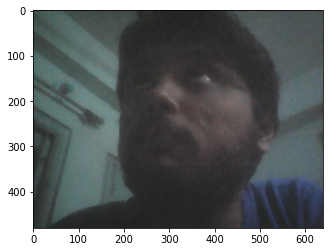

Diptendu


In [62]:
arr = extract_face('/home/arko/Documents/Python_Scripts/Capstone_Project/data/test/diptendu/diptendu_test_0.jpg')

arr_embed = get_embedding(model, arr)

distances = []
for i in range(train_embeddings.shape[0]):
    distance = np.linalg.norm(arr_embed - train_embeddings[i])
    distances.append(distance)
distances = np.asarray(distances)
print(distances)
idx = distances.argmin()
path = train_gen.filepaths[idx]
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

label = train_gen.classes[idx]
print(list(train_gen.class_indices.keys())[list(train_gen.class_indices.values()).index(label)])

In [ ]:
img = mpimg.imread('/home/arko/Documents/Python_Scripts/Capstone_Project/data/test/arko/arko_test.jpg')
imgplot = plt.imshow(img)
plt.show()

In [21]:
def cam_capture():
    cam = cv2.VideoCapture(0)

    cv2.namedWindow("test")

    img_counter = 0

    while True:
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        cv2.imshow("test", frame)

        k = cv2.waitKey(1)
        if k%256 == 27:
           # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
        # SPACE pressed
            img_name = "opencv_frame_{}.jpg".format(img_counter)
            cv2.imwrite('/home/arko/Documents/Python_Scripts/Capstone_Project/open_cv/' + img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

    cam.release()

    cv2.destroyAllWindows()

In [50]:
filename = '/home/arko/Documents/Python_Scripts/Capstone_Project/open_cv/opencv_frame_0.jpg'

In [63]:
def face_recog(filename, required_size=(160, 160)):
    
    ############ FACE-EXTRACTION ##############
    image = load_img(filename)
    image_arr = img_to_array(image)
    
    detector = MTCNN()
    results = detector.detect_faces(image_arr)
    
    # extract the bounding box from the first face
    #print(results)
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    #face_extraction
    face_arr = image_arr[y1:y2, x1:x2]
    #resizing for facenet with appropriate pixels
    face_image = array_to_img(face_arr)
    face_image = face_image.resize(required_size)
    face_arr = img_to_array(face_image)
    face_pixels = face_arr
    
    ##############Embedding######################
    
    #model = load_model(model)
    face_pixels = face_pixels.astype('float32')
    
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    arr_embed = yhat[0]

    ############# RECOGNITION ###############
    

    distances = []
    for i in range(train_embeddings.shape[0]):
        distance = cosine(arr_embed,train_embeddings[i])
        distances.append(distance)
    distances = np.asarray(distances)
    #print(distances)
    idx = distances.argmin()
    #print(distances[idx])
   
    min_dist=distances[idx]
    
    if(min_dist<=0.3):
        #path = filepaths[idx]
        #img = mpimg.imread(path)
        #imgplot = plt.imshow(img)
        #plt.show()
        label = classes[idx]
        match_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        return match_name
    
    elif(min_dist <=0.6):
        s = "please retake the image"
        return s
    
    else:
        s = "Access Denied"
        return s

In [34]:
pip install dill

     |████████████████████████████████| 81 kB 1.1 MB/s eta 0:00:011
You should consider upgrading via the '/home/arko/My_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [64]:
import dill

filename = 'recognition.pickle'
dill.dump(face_recog, open(filename, 'wb'))

In [51]:
data = np.load('train_embeddings.npz')
train_embeddings, filepaths, classes = data['arr_0'], data['arr_1'], data['arr_2']

file = open("train_labels",'rb')
class_indices = pickle.load(file)
file.close()

In [65]:
model = load_model('facenet_keras.h5')
print("done")

done


In [57]:
cam_capture()
face_recog(filename)

opencv_frame_0.jpg written!
Escape hit, closing...


'arko'